# drawing functions

In [1]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def rct(draw, x, y, fill=True):
    lt = (x*SIZE + OFFSET, y*SIZE + OFFSET)
    rt = ((x+1)*SIZE + OFFSET, y*SIZE + OFFSET)
    rb = ((x+1)*SIZE + OFFSET, (y+1)*SIZE + OFFSET)
    lb = (x*SIZE + OFFSET, (y+1)*SIZE + OFFSET)
    fill = 200 if fill else 0
    draw.polygon([lt, rt, rb, lb], outline=255, fill=fill)


# im = Image.new('L', (300,300))
# draw = ImageDraw.Draw(im)
# rct(draw, 1, 1)
# rct(draw, 2, 1)
# rct(draw, 3, 1, False)
# rct(draw, 0, 0, False)
# im

def draw_board(bits):
    font = ImageFont.truetype("OpenSans-Regular.ttf", 20) # https://fonts.google.com/specimen/Open+Sans
    
    dim = len(np.array(bits).shape)
    if dim==1:
        bits = [bits]
    r, c = np.array(bits).shape
    h = r*SIZE + 2*OFFSET
    w = c*SIZE + 2*OFFSET
    im = Image.new('L', (w,h))
    draw = ImageDraw.Draw(im)
    for i,r in enumerate(bits):
        for j,c in enumerate(r):
            rct(draw, j, i, c==True)
            draw.text((OFFSET + 4 + j*SIZE, OFFSET + i*SIZE), str(j+1), font=font, fill=255)
        
    return im


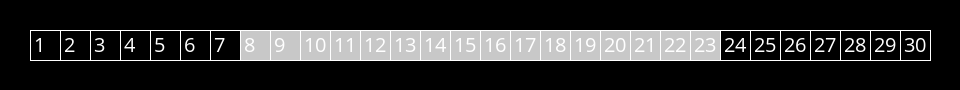

In [2]:
SIZE=30
OFFSET=30

def digit2bit(digits):
    r = []
    for d in digits:
        r.extend([1 for _ in range(d)])
        r.append(0)
    
    return r[:-1]

def check_inevitable(total, digits):
    # A function for testing purposes. 
    # Finally we used a simple but inefficient algorithm, so we don't use this function further.
    shortest = sum(digits) + len(digits) - 1
    buf = total - shortest
    r = []
    for d in digits:
        if d > buf:
            for _ in range(buf):
                r.append(0)
            for _ in range(d-buf):
                r.append(1)
        else:
            for _ in range(d):
                r.append(0)
        
        r.append(0)
    r = r[:-1]
    for _ in range(total-len(r)):
        r.append(0)
    return r



    
d = check_inevitable(30, [23])
draw_board(d)

In [3]:
def get_possibles(total_len, digits):

    if len(digits)-1+sum(digits) > total_len:
        return None
    
    d = digits[0]
    if len(digits)==1:
        r = []
        for buf in range(total_len - d + 1):
            a = []
            for _ in range(buf):
                a += [0]
            for _ in range(d):
                a += [1]
            for _ in range(total_len - buf - d):
                a += [0]
            r += [a]
        return r
    else:
        rs = []
        for buf in range(total_len - sum(digits)):
            r = []
            for _ in range(buf):
                r += [0]
            for _ in range(d):
                r += [1]
            r += [0]
            possibles = get_possibles(total_len - len(r), digits[1:])
            if possibles is None:
                pass
            else:
                for p in possibles:
                    r1 = r[:]
                    r1.extend(p)
                    rs += [r1]
        return rs
    
#draw_board(get_possibles(10, [1,2,3]))

In [43]:
def solve_line(candidates, cur_status):
    # filtering by cur_status
    candidates = np.array(candidates)
    for i, d in enumerate(cur_status):
        if d==-1:
            continue
            
        candidates = candidates[candidates[:,i]==d]
    if len(candidates)==0:
        return None
    # set next_status
    sumline = candidates.sum(axis=0)
    next_status = np.array([-1]*len(cur_status))
    next_status[sumline==len(candidates)] = 1
    next_status[sumline==0] = 0
    return next_status


def brutal_force(status, h_nums, v_nums, candidates):
    _status = np.copy(status)
    _candidates = np.copy(candidates)
    maxprob = 0
    maxrow = -1
    maxcol = -1
    for i, c in enumerate(_candidates):
        probs = np.sum(c, axis=0)*1./len(c)
        if i<30:
            probs[status[i] > -1 ] = 0
        else:
            probs[status[:, i-30] > -1 ] = 0
        where = np.argmax(probs)
        if maxprob < probs[where]:
            maxprob = probs[where]
            maxrow = i
            maxcol = where
            
    r,c = 0,0
    if maxrow < 0:
        r, c = np.where(_status==-1)
        if len(r)<1:
            return False
        else:
            r,c = r[0],c[0]
    else:
        if maxrow > 30:
            r, c = maxcol, maxrow-30
        else:
            r, c = maxrow, maxcol
    print(f'at {r},{c}. value:{_status[r,c]}, to:1')
    _status[r,c] = 1
    assert np.any(status != _status)
    
    return solve(_status, h_nums, v_nums, _candidates)


def solve(all_status, h_nums, v_nums, all_candidates=None):

    if all_candidates is None:
        print('calculating all possibilities. about 5-6 sec.')
        h_candidates = [get_possibles(30, x) for x in h_nums]
        v_candidates = [get_possibles(30, x) for x in v_nums]
        all_candidates = np.hstack([np.copy(h_candidates), np.copy(v_candidates)])
        print('OK')

    before_stat = -1
    for it in range(30):
        for i, line in enumerate(all_status):
            next_status = solve_line(all_candidates[i], line)
            if next_status is None:
                return False
            all_status[i] = next_status
        for i, line in enumerate(all_status.T):
            next_status = solve_line(all_candidates[len(all_status)+i], line)
            all_status[:,i] = next_status

        draw_status = np.copy(all_status)
        draw_status[draw_status==-1] = 0

        #display(draw_board(draw_status))
        
        cur_stat = np.sum(all_status==-1)
        print(f'({it}) {cur_stat}')
        if cur_stat==0:
            display(draw_board(draw_status))
            print('total', it, 'iterations')
            return True
        else:
            if cur_stat == before_stat:
                print('impossible case.', cur_stat)
                brutal_force(all_status, h_nums, v_nums, all_candidates)
                break
            else:
                before_stat = cur_stat

        
    

# easy case

calculating all possibilities. about 5-6 sec.
OK
(0) 826
(1) 780
(2) 695
(3) 593
(4) 524
(5) 440
(6) 371
(7) 341
(8) 289
(9) 255
(10) 217
(11) 182
(12) 144
(13) 91
(14) 29
(15) 6
(16) 0


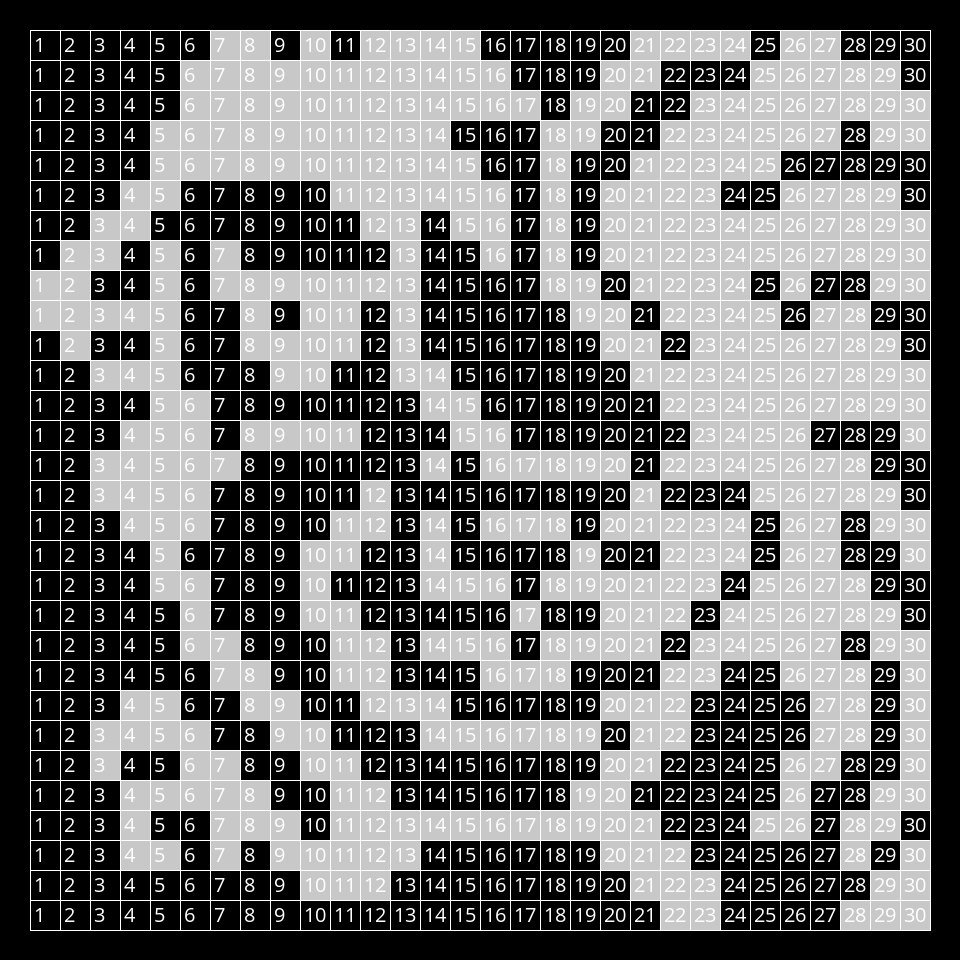

total 16 iterations


True

In [45]:

horis = [[2, 1, 4, 4, 2],
 [11, 2, 5],
 [12, 2, 8],
 [10, 2, 6, 2],
 [11, 1, 5],
 [2, 6, 1, 4, 4],
 [2, 2, 2, 1, 11],
 [2, 1, 1, 1, 1, 1, 11],
 [2, 1, 7, 2, 4, 1, 2],
 [5, 1, 2, 1, 2, 4, 2],
 [1, 1, 4, 1, 2, 7],
 [3, 2, 2, 10],
 [2, 2, 9],
 [3, 4, 2, 4, 1],
 [5, 1, 5, 7],
 [4, 1, 1, 5],
 [3, 2, 1, 3, 5, 2, 2],
 [1, 2, 1, 1, 3, 2, 1],
 [2, 1, 3, 6, 4],
 [1, 2, 1, 3, 6],
 [2, 2, 3, 4, 5, 2],
 [2, 2, 3, 2, 3, 1],
 [2, 2, 3, 3, 2, 1],
 [4, 2, 6, 2, 2, 1],
 [1, 2, 2, 2, 2, 1],
 [5, 2, 2, 1, 2],
 [1, 3, 11, 2, 2],
 [2, 1, 5, 3, 1, 1],
 [3, 3, 2],
 [2, 3]]
vertis = [[2],
 [4],
 [2, 1, 1, 2, 2],
 [2, 1, 1, 4, 2, 3],
 [3, 12, 2, 1, 1],
 [4, 5, 3, 3],
 [5, 2, 1, 2, 4],
 [5, 3, 1, 2, 2],
 [4, 1, 2, 1, 2, 2],
 [5, 4, 1, 3, 2, 2],
 [5, 3, 1, 2, 3, 5],
 [7, 1, 2, 3, 4],
 [12, 1, 2],
 [6, 2, 1, 3, 1, 2, 1],
 [3, 3, 2, 1, 1, 1, 1],
 [2, 3, 2, 1, 1, 2, 1, 1],
 [1, 1, 1, 1, 1, 1, 1],
 [6, 1, 1, 1, 2, 1, 1],
 [2, 2, 1, 2, 1, 1, 2],
 [2, 3, 2, 1, 1, 3, 1, 4],
 [2, 5, 2, 2, 3, 3, 3],
 [1, 7, 2, 1, 4, 3, 3],
 [1, 13, 3, 2, 2],
 [1, 3, 9, 2, 2],
 [4, 2, 7, 3, 1],
 [4, 4, 12, 3],
 [4, 3, 4, 11],
 [2, 3, 4, 2, 2, 3, 2, 1],
 [3, 4, 3, 2, 2, 2, 2],
 [2, 3, 3, 2, 6, 3]]

all_status = np.ones((30,30), dtype=int) * -1
solve(all_status, horis, vertis)

# hard case

calculating all possibilities. about 5-6 sec.
OK
(0) 592
(1) 302
(2) 203
(3) 180
(4) 170
(5) 165
(6) 165
impossible case. 165
at 14,13. value:-1, to:1
(0) 163
(1) 163
impossible case. 163
at 13,7. value:-1, to:1
(0) 157
(1) 121
(2) 97
(3) 69
(4) 52
(5) 36
(6) 26
(7) 13
(8) 2
(9) 0


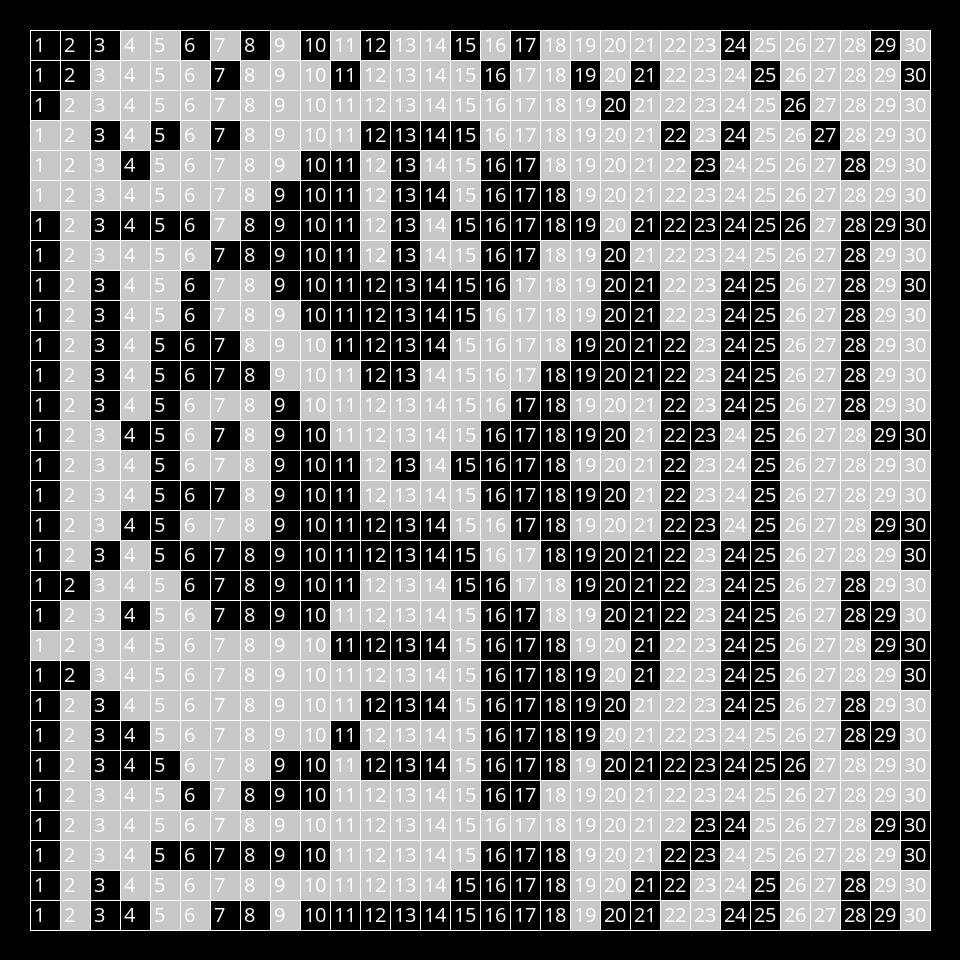

total 9 iterations


In [46]:

rows = '''
2 1 1 1 2 1 6 4 1
4 3 4 2 1 3 4
18 5 4
2 1 1 4 6 1 2 3
3 5 1 2 5 4 2
8 1 1 12
1 1 1 1 1 1
5 1 2 2 7 2
1 2 2 3 2 2 1
1 2 3 4 2 2 2
1 1 3 4 1 2 2
1 1 3 4 1 2 2
1 1 3 7 3 1 2 2
2 1 1 5 1 1 3
3 3 1 1 3 2 5
3 1 4 1 2 5
2 3 2 3 1 3
1 1 2 1 4
3 3 2 1 2 2
2 2 5 2 1 2 1
10 1 2 2 3
13 1 2 4
1 8 1 3 2 2
1 6 4 8 1
1 3 1 1 1 4
4 1 5 13
21 4
3 5 3 6
1 11 2 2 2 2
1 2 1 1 2 2 1
'''
cols='''
3 1 
16 2 8
2 2 1 4 4 3
4 1 6 2 2 3 4
3 2 3 6 2 2
5 1 3 1 6 1 2 
1 1 3 2 1 1 1 7 1
5 3 5 5 1 1
5 3 4 1 2 
3 3 4 1 1 
1 2 3 1 2 5
2 4 4 2 1 1 4
3 2 1 2 1 1 4
3 1 2 5 2 1 1 4
2 2 1 4 2 9
1 2 4 2 1 
3 4 2 1 
5 4 2 2 
1 4 3 1 1 1 2 6
2 4 1 1 1 2 1 4
1 4 1 5 2 3
3 2 3 4 2 1
4 1 6 2 7 1 2
2 2 1 4 1 1 2
1 4 1 1 3
2 3 17 5
3 26
4 1 5 2 4
5 6 2 2 2 2 2
1 4 1 4 2 2 4 2
'''
horis = [[int(x) for x in l.split()] for l in rows.strip().split('\n')]
vertis = [[int(x) for x in l.split()] for l in cols.strip().split('\n')]


all_status = np.ones((30,30), dtype=int) * -1
solve(all_status, horis, vertis)